# Data Scientist Challenge

In this challenge, you are assuming the position of a data scientist for a large corporation with offices in many states. The company you work for is looking to gain insights from its purchase order data during the year 2014. You have 10,000 different purchase orders from different states. The state, date, and revenue are recorded from each purchase order.

The company is primarily interested in determining what is happening to revenue over time and what strategy should be undertaken to maximize revenue.

You don't need any advanced statistics for this assignment. Good exploratory data analysis and visualizations will reveal the key insights.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [2]:
orders = pd.read_csv('../data/orders.csv', parse_dates=['order_date'])
orders.head()

,state,order_date,revenue
0,Arkansas,2014-12-24,1311.0
1,Florida,2014-10-15,698.0
2,Iowa,2014-09-07,1193.0
3,Indiana,2014-05-19,469.0
4,Maine,2014-04-19,334.0


## Executive Summary

Revenue per order is declining for each state over the course of the year. This is a surprising finding at first because average revenue and total revenue overall are increasing. The reason this occurred is because the states with high average revenue greatly increased their total number of orders as the year went on. The states that had low average revenue decreased in frequency of orders from the start of the year. This current trend may or may not necessarily indicate a problem but it certainly cannot continue indefinitely.

## Data Inspection

Get a brief summary description of the columns.

In [3]:
orders.shape

(10000, 3)

In [4]:
orders.dtypes

state                 object
order_date    datetime64[ns]
revenue              float64
dtype: object

In [5]:
orders.isna().sum()

state         0
order_date    0
revenue       0
dtype: int64

### Change data types

State is a nominal categorical variable. We change it below.

In [6]:
orders['state'] = orders['state'].astype('category')
orders.dtypes

state               category
order_date    datetime64[ns]
revenue              float64
dtype: object

### Data dictionary

Begin by creating a dictionary with two values, one for the columns, and the other for the description.

In [7]:
d = {'column': ['state', 'order_date', 'revenue'], 
     'description': ['state name', 'purchase order date', 'revenue of order']}
dd = pd.DataFrame(d)
dd

,column,description
0,state,state name
1,order_date,purchase order date
2,revenue,revenue of order


Set the index to be the column names so that you can automatically align each new column of values to the correct column name.

In [8]:
dd = dd.set_index('column')
dd

,description
column,
state,state name
order_date,purchase order date
revenue,revenue of order


Add in the type of column (nominal, ordinal, or continuous), missing values, and number of unique values.

In [9]:
dd['type'] = pd.Series({'state': 'nominal', 'order_date': 'ordinal', 'revenue': 'continuous'})
dd['missing'] = orders.isna().sum()
dd['num unique'] = orders.nunique()
dd

,description,type,missing,num unique
column,,,,
state,state name,nominal,0,25
order_date,purchase order date,ordinal,0,360
revenue,revenue of order,continuous,0,1368


Add the minimum and maximum counts for each column.

In [10]:
def find_agg(dd, df, kind):
    cols = df.columns
    types = dd['type'] # series
    vals = {}
    for col in cols:
        t = types.loc[col] # nominal, ordinal, or continuous
        if t in ('nominal', 'ordinal'):
            idx = 0 if kind == 'max' else -1
            vc = df[col].value_counts()
            val = vc.index[idx], vc.iloc[idx]
        else:
            val = df[col].agg(kind)
        vals[col] = val
    return pd.Series(vals)

In [11]:
dd['min'] = find_agg(dd, orders, 'min')
dd['max'] = find_agg(dd, orders, 'max')
dd

,description,type,missing,num unique,min,max
column,,,,,,
state,state name,nominal,0,25,"(Idaho, 341)","(New York, 485)"
order_date,purchase order date,ordinal,0,360,"(2014-06-05 00:00:00, 15)","(2014-10-15 00:00:00, 48)"
revenue,revenue of order,continuous,0,1368,98,1765


## Time series data

Sort by order date and state. A new DataFrame is created with order_date in the index. Plotting is actually easier with the datetime column as an actual column and not in the index, so we keep two copies of the data here.

In [12]:
orders = orders.sort_values(['order_date', 'state'])
orders_ts = orders.set_index('order_date')
orders_ts

,state,revenue
order_date,,
2014-01-01,Alaska,678.0
2014-01-01,Alaska,783.0
2014-01-01,Alaska,608.0
2014-01-01,Alaska,664.0
2014-01-01,California,740.0
...,...,...
2014-12-26,Texas,1169.0
2014-12-26,Texas,1050.0
2014-12-26,Texas,1251.0


In [13]:
orders.head()

,state,order_date,revenue
156,Alaska,2014-01-01,678.0
1841,Alaska,2014-01-01,783.0
2495,Alaska,2014-01-01,608.0
8587,Alaska,2014-01-01,664.0
292,California,2014-01-01,740.0


Reset and drop index to get index beginning at 0 again.

In [14]:
orders = orders.reset_index(drop=True)
orders.head()

,state,order_date,revenue
0,Alaska,2014-01-01,678.0
1,Alaska,2014-01-01,783.0
2,Alaska,2014-01-01,608.0
3,Alaska,2014-01-01,664.0
4,California,2014-01-01,740.0


## Univariate analysis

### State

Count of orders per state.

In [15]:
vc = orders['state'].value_counts()
vc

New York       485
Alaska         477
Maine          468
Oregon         461
Oklahoma       445
California     444
Mississippi    442
Indiana        424
Nebraska       414
Texas          403
Kansas         403
Ohio           398
Nevada         394
Illinois       381
Missouri       379
Louisiana      375
Florida        374
Washington     370
Montana        369
Iowa           362
Georgia        355
Delaware       349
New Mexico     344
Arkansas       343
Idaho          341
Name: state, dtype: int64

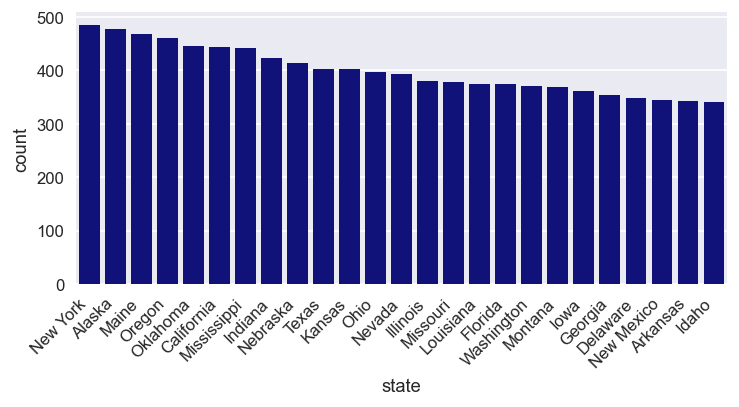

In [16]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=120)
sns.countplot(x='state', data=orders, ax=ax, order=vc.index, color='darkblue')
ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45);

### Order date

In [17]:
orders_per_day = orders_ts.resample('D').size()
orders_per_day

order_date
2014-01-01    28
2014-01-02    25
2014-01-03    19
2014-01-04    24
2014-01-05    21
              ..
2014-12-22    34
2014-12-23    35
2014-12-24    34
2014-12-25    30
2014-12-26    35
Freq: D, Length: 360, dtype: int64

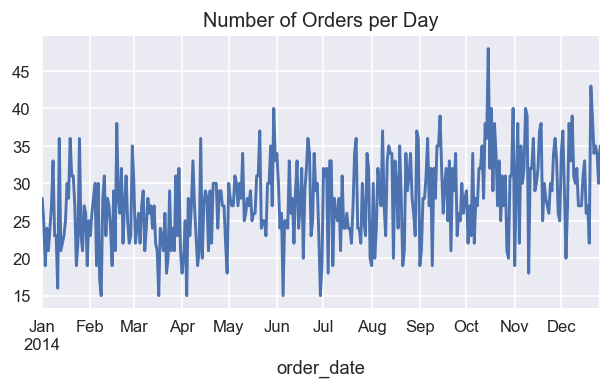

In [18]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
orders_per_day.plot(title='Number of Orders per Day');

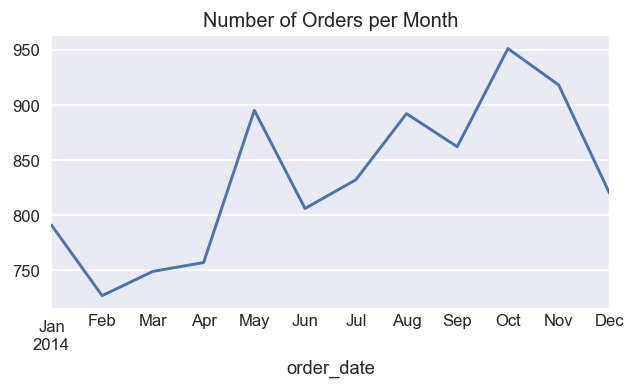

In [19]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
orders_per_month = orders_ts.resample('M').size()
orders_per_month.plot(title='Number of Orders per Month');

### Revenue

Only continuous column. Let's find summary statistics and distribution plots

In [20]:
orders['revenue'].describe().astype('int64')

count    10000
mean       887
std        317
min         98
25%        640
50%        830
75%       1164
max       1765
Name: revenue, dtype: int64

Total revenue

In [21]:
orders['revenue'].sum()

8877425.0

Box plot reveals no clear outliers.

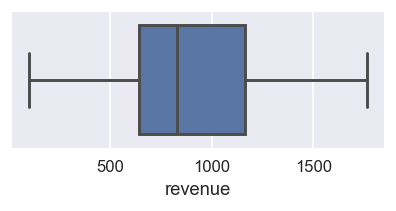

In [22]:
fig, ax = plt.subplots(figsize=(4, 1.5), dpi=120)
sns.boxplot('revenue', data=orders, ax=ax);

KDE and histogram show clear bimodal distribution. Need more information to understand it.

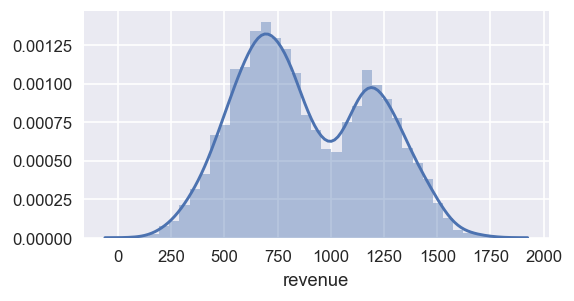

In [23]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi=120)
sns.distplot(orders['revenue'], ax=ax);

## Multivariate analysis

* Revenue over time
* Revenue by state
* Revenue by state over time

### Revenue over time

A scatterplot of revenue over time is created. There appear to be two groups, one with higher revenue and one with lower.

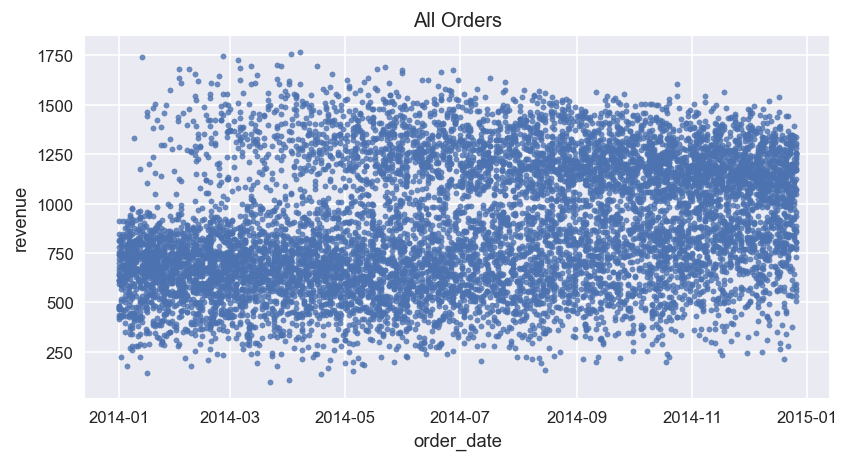

In [24]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
orders.plot(x='order_date', y='revenue', kind='scatter', s=10, alpha=.8, ax=ax, title='All Orders');

### hexbin plots for better distribution understanding

The matplotlib `hexbin` plotting function is an aggregated scatter plot that uses hexagons instead of points. It colors each hexagon proportional to the number of points inside it. When there are many overlapping points, hexbins can provide a much better picture of the overall distribution. Unfortunately, they don't work well with datetime data, so we create an integer column 'doy' to hold the day of the year.

In [25]:
orders['doy'] = orders['order_date'].dt.dayofyear
orders.head()

,state,order_date,revenue,doy
0,Alaska,2014-01-01,678.0,1
1,Alaska,2014-01-01,783.0,1
2,Alaska,2014-01-01,608.0,1
3,Alaska,2014-01-01,664.0,1
4,California,2014-01-01,740.0,1


By default, hexbins count the number of points in each hexagon.

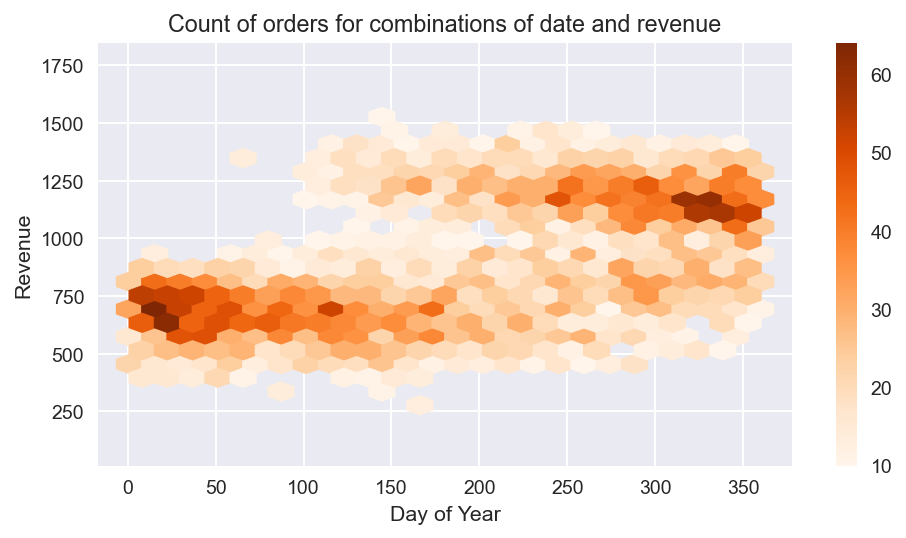

In [26]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=140)
hb = ax.hexbin('doy', 'revenue', gridsize=25, data=orders, cmap='Oranges', mincnt=10, )
fig.colorbar(hb)
ax.set_title('Count of orders for combinations of date and revenue')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Revenue');

 We can aggregate any other variable instead and choose to sum the revenue.

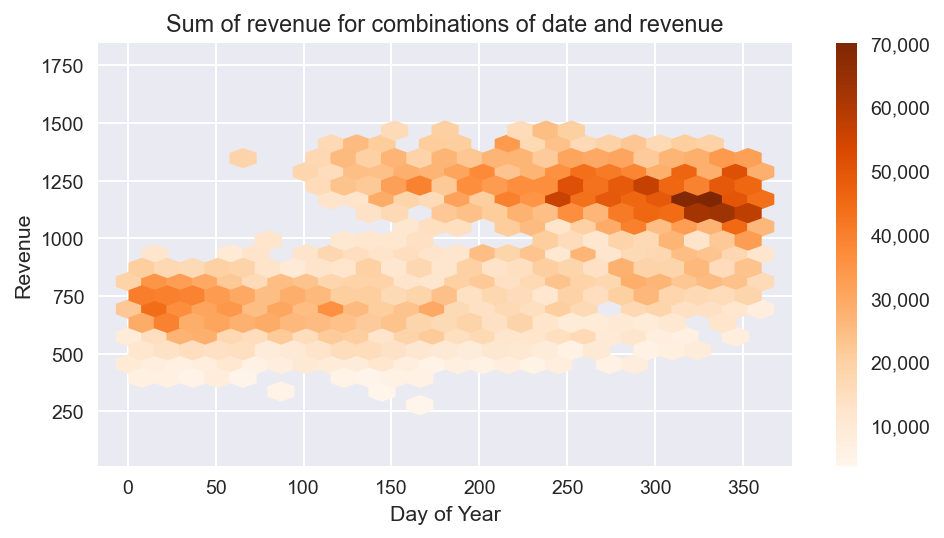

In [27]:
from matplotlib import ticker
fig, ax = plt.subplots(figsize=(8, 4), dpi=140)
hb = ax.hexbin('doy', 'revenue', C=orders['revenue'], gridsize=25, data=orders, cmap='Oranges', 
                mincnt=10, reduce_C_function=np.sum)
fig.colorbar(hb, format=ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_title('Sum of revenue for combinations of date and revenue')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Revenue');

### Total and average revenue along with number of orders per month

In [28]:
rev_per_month = orders_ts.resample('M')['revenue'].agg(['mean', 'sum', 'count']).astype('int64')
rev_per_month

,mean,sum,count
order_date,,,
2014-01-31,679,537733,791
2014-02-28,735,534894,727
2014-03-31,769,576577,749
2014-04-30,816,618229,757
2014-05-31,860,770376,895
2014-06-30,877,707292,806
2014-07-31,920,765917,832
2014-08-31,949,846619,892
2014-09-30,972,838562,862


All values have increased since the start of the year. These graphs make it look like the company is doing well.

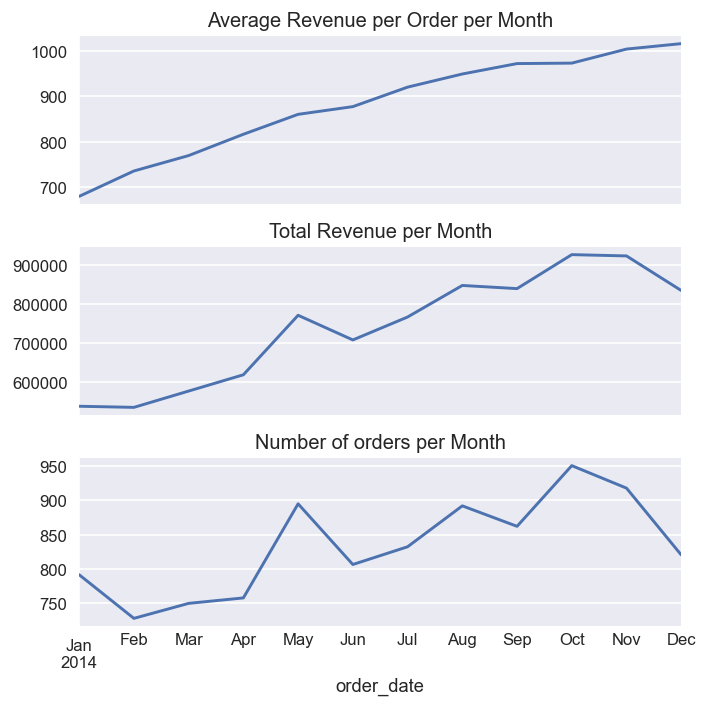

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6), dpi=120, tight_layout=True, sharex=True)
rev_per_month['mean'].plot(kind='line', ax=ax1, title='Average Revenue per Order per Month');
rev_per_month['sum'].plot(kind='line', ax=ax2, title='Total Revenue per Month');
rev_per_month['count'].plot(kind='line', ax=ax3, title='Number of orders per Month');

## Revenue by state

Average revenue per state is calculated and plotted below. There is a huge difference between states with several clustering together with the same exact revenue.

In [30]:
agg_rev = orders.groupby('state').agg(avg_revenue=('revenue', 'mean'),
                                      total_revenue=('revenue', 'sum')) \
                .sort_values('avg_revenue').round(-1).astype('int64')
agg_rev

,avg_revenue,total_revenue
state,,
Maine,380,177080
Nevada,470,183410
Indiana,560,237680
Oklahoma,560,249660
Ohio,650,257680
California,650,288660
Mississippi,650,289260
Alaska,650,312210
Oregon,750,344240


Plot results with seaborn.

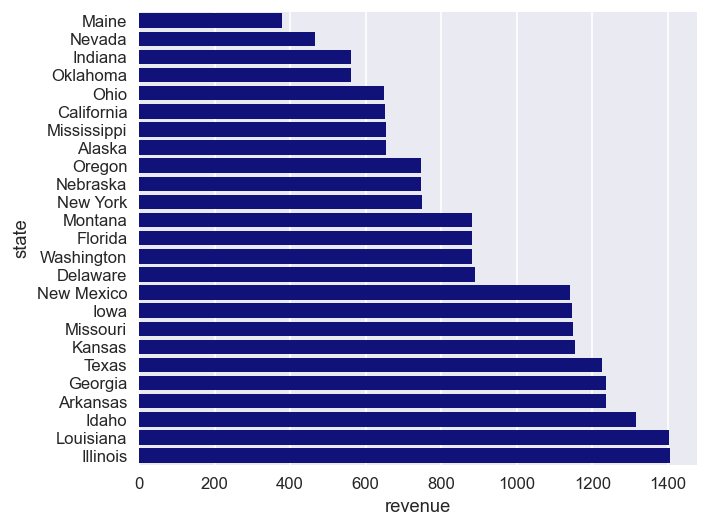

In [31]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
sns.barplot(x='revenue', y='state', data=orders, estimator=np.mean, 
            ax=ax, ci=None, order=agg_rev.index, color='darkblue');

## Revenue per state over time

### Total Revenue by State per month

Must use `pd.Grouper` to group by a datetime and another column.

In [32]:
tg = pd.Grouper(key='order_date', freq='M')
orders_state_total = orders.pivot_table(index=tg, columns='state', 
                                        values='revenue', aggfunc='sum').round(-1).astype('int64')
orders_state_total

state,Alaska,Arkansas,California,Delaware,Florida,Georgia,Idaho,Illinois,Indiana,Iowa,...,Montana,Nebraska,Nevada,New Mexico,New York,Ohio,Oklahoma,Oregon,Texas,Washington
order_date,,,,,,,,,,,,,,,,,,,,,
2014-01-31,46850,1440,57490,3250,5030,2870,4540,1740,38610,3670,...,3740,45510,26240,1420,56640,44280,44280,54840,1300,2040
2014-02-28,50930,10730,34940,8060,8010,12980,5770,9940,26020,10140,...,4560,38360,28120,7340,46120,37830,34880,48570,10070,4020
2014-03-31,37860,9600,34560,8720,10540,16700,15600,27770,28270,11400,...,17470,45910,27620,10580,50920,30250,31230,36390,14420,12120
2014-04-30,35960,14500,32920,26430,13110,20010,20520,26870,21640,20110,...,14280,36720,17230,17660,43190,25930,27760,40050,26870,13360
2014-05-31,34680,33600,23480,25920,23560,34600,38020,38580,28690,34830,...,27960,30010,17540,26180,35650,24090,26470,39890,36360,25060
2014-06-30,21120,36760,26400,22440,33540,29900,33990,49980,22340,29650,...,21160,26330,21330,37660,25730,25390,22300,23100,32960,25520
2014-07-31,20750,40460,19120,24870,32780,51000,46120,43170,19620,44580,...,27390,22400,13130,34210,32560,15670,17330,25320,51150,35670
2014-08-31,20420,47750,20220,28130,37440,36250,45470,63980,20310,45930,...,37480,25460,10520,54100,20410,15790,15680,23110,48350,34210
2014-09-30,15130,53740,11080,32590,31120,61040,44140,57520,10260,52080,...,37590,12260,8460,54340,17320,14870,11550,16400,57370,45990


Some states are increasing total revenue, others are decreasing.

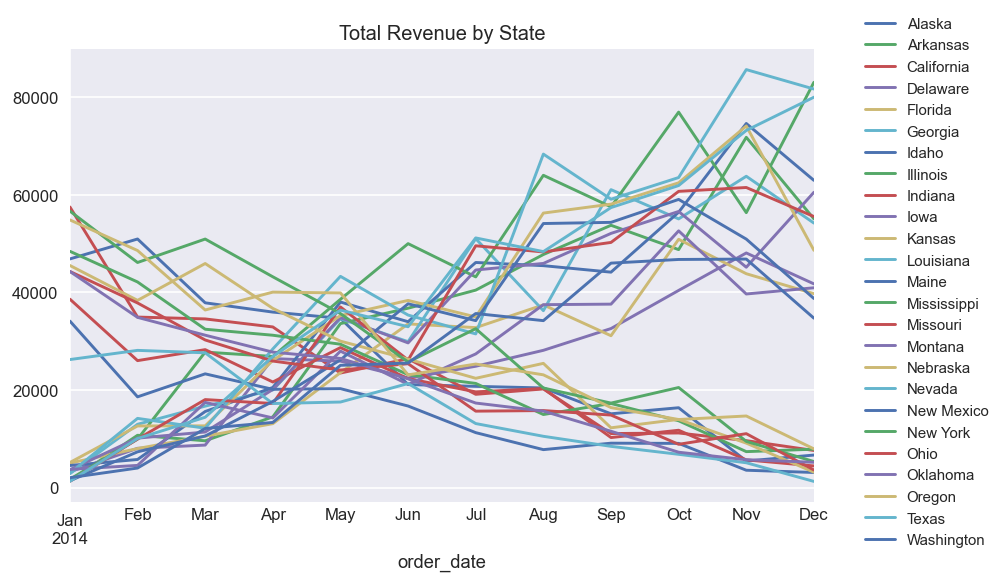

In [33]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
orders_state_total.plot(ax=ax, title='Total Revenue by State')
ax.legend(bbox_to_anchor=(1.05, 1.1), fontsize=9);

### Average revenue by state per month

Along with total revenue, we can plot average revenue per state by month. This plot is even more interesting. All of the states have decreasing average revenue over time. This is potentially very bad. Perhaps, market share is being gained by sacrificing the price per order.

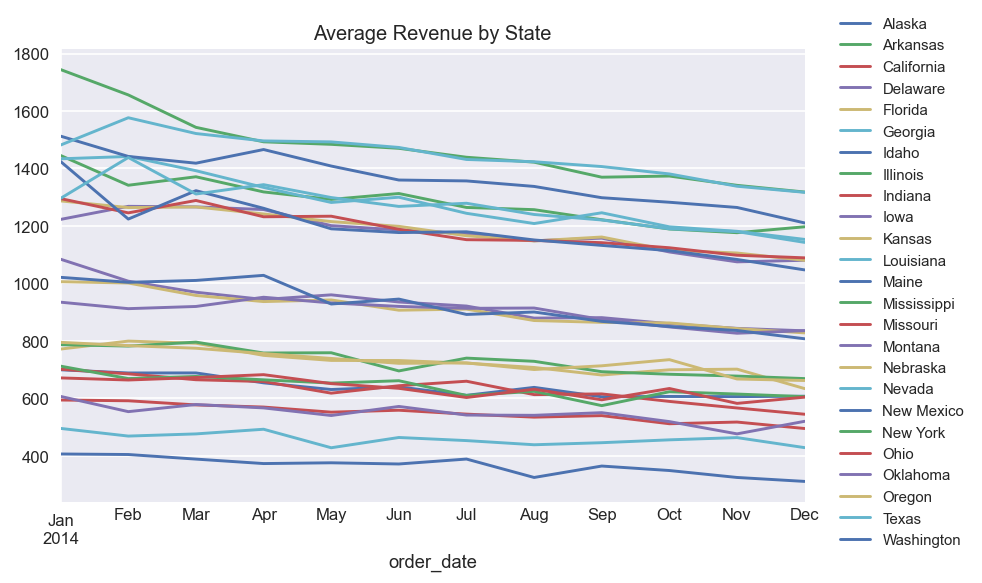

In [34]:
orders_state_avg = orders.pivot_table(index=tg, columns='state', values='revenue', aggfunc='mean')
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
orders_state_avg.plot(ax=ax, title='Average Revenue by State');
ax.legend(bbox_to_anchor=(1.03, 1.1), fontsize=9);

### Number of orders by state per month

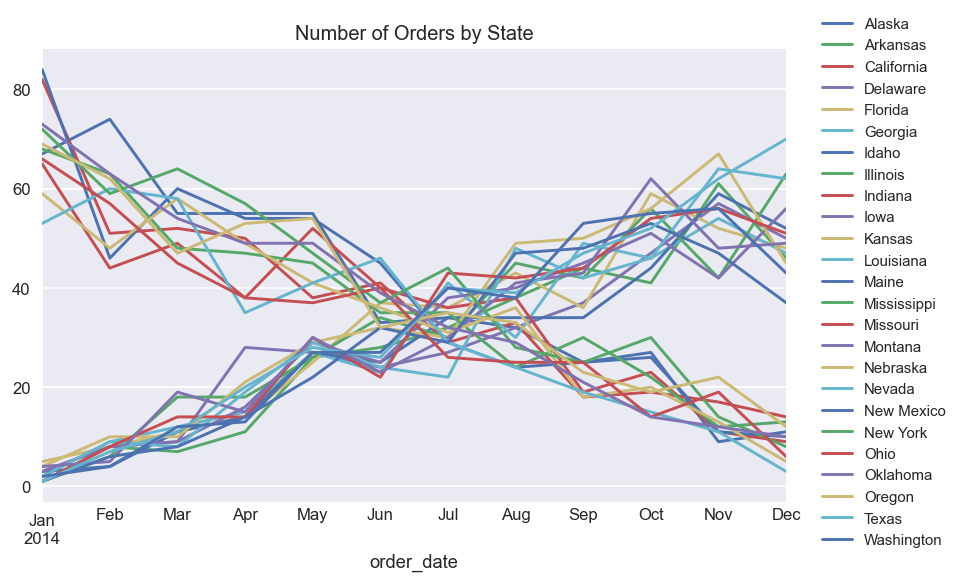

In [35]:
orders_state_avg = orders.pivot_table(index=tg, columns='state', values='revenue', aggfunc='count')
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
orders_state_avg.plot(ax=ax, title='Number of Orders by State');
ax.legend(bbox_to_anchor=(1.03, 1.1), fontsize=9);

### Overall Average and Total revenue increasing, but every average order per state per month decreasing. Why?

Overall total and average revenue increased throughout the year which looks fantastic but average revenue on a state-by-state basis is falling for every state. This seems like a paradox. 

Some states are increasing total revenue over time with others decreasing total revenue over time.

### Two state groups

There seems to be two distinct groups of states based on total revenue increasing/decreasing over the year.

### Making a group column

We will make a new column in our DataFrame that categorizes each state as **Up** or **Down** based on the total revenue over the year. To do this, we will compare the first row (January) to the last row (December) from the **`orders_state_total`** table.

In [36]:
jan = orders_state_total.iloc[0]
dec = orders_state_total.iloc[-1]
states_up = jan < dec
states_up

state
Alaska         False
Arkansas        True
California     False
Delaware        True
Florida         True
Georgia         True
Idaho           True
Illinois        True
Indiana        False
Iowa            True
Kansas          True
Louisiana       True
Maine          False
Mississippi    False
Missouri        True
Montana         True
Nebraska       False
Nevada         False
New Mexico      True
New York       False
Ohio           False
Oklahoma       False
Oregon         False
Texas           True
Washington      True
dtype: bool

Let's use boolean selection to retrieve the Up states.

In [43]:
state_names_up = states_up[states_up].index
state_names_up.to_numpy()

array(['Arkansas', 'Delaware', 'Florida', 'Georgia', 'Idaho', 'Illinois',
       'Iowa', 'Kansas', 'Louisiana', 'Missouri', 'Montana', 'New Mexico',
       'Texas', 'Washington'], dtype=object)

Create new column for the revenue group. By default, make each 'Down'. Use boolean selection to change the value for the Up states.

In [38]:
orders['revenue_group'] = 'Down'
filt = orders['state'].isin(state_names_up)
orders.loc[filt, 'revenue_group'] = 'Up'
orders.head()

,state,order_date,revenue,doy,revenue_group
0,Alaska,2014-01-01,678.0,1,Down
1,Alaska,2014-01-01,783.0,1,Down
2,Alaska,2014-01-01,608.0,1,Down
3,Alaska,2014-01-01,664.0,1,Down
4,California,2014-01-01,740.0,1,Down


## Revenue by revenue group over time

Let's redo the above analysis using the revenue group instead of the state.

In [39]:
tg = pd.Grouper(freq='M', key='order_date')
updown_summary = orders.pivot_table(index=tg, columns='revenue_group', 
                                    values='revenue', aggfunc=['mean', 'sum', 'count']) \
                       .round(-1).astype('int64')
updown_summary

mean           sum         count     
revenue_group Down    Up    Down      Up  Down   Up
order_date                                         
2014-01-31     660  1230  497280   40450   760   30
2014-02-28     650  1280  406500  128400   630  100
2014-03-31     640  1240  378780  197800   590  160
2014-04-30     630  1230  332770  285460   520  230
2014-05-31     600  1200  310180  460200   510  380
2014-06-30     600  1190  253880  453410   420  380
2014-07-31     610  1160  218520  547400   360  470
2014-08-31     600  1150  194690  651930   330  570
2014-09-30     580  1130  143670  694890   250  610
2014-10-31     580  1100  133530  791900   230  720
2014-11-30     580  1090   86880  835270   150  770
2014-12-31     560  1080   56310  777340   100  720

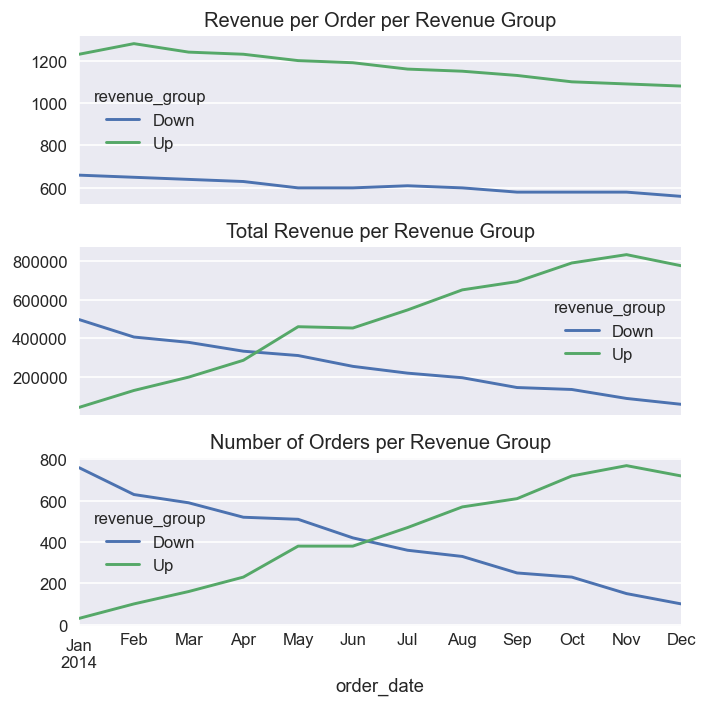

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6), dpi=120, tight_layout=True, sharex=True)
updown_summary['mean'].plot(ax=ax1, title='Revenue per Order per Revenue Group')
updown_summary['sum'].plot(ax=ax2, title='Total Revenue per Revenue Group')
updown_summary['count'].plot(ax=ax3, title='Number of Orders per Revenue Group');

## Frequency of orders per revenue group

The frequency of the orders per revenue group is plotted. This figure shows a very interesting trend. The Down group is making much fewer orders over the course of the year and in fact some states are heading towards no orders at all. The Up group on the other hand is making more orders every month.

We can now explain the paradox of increasing overall total and average revenue with every state decreasing average revenue per order. The states with high average revenue orders (Up states) had few orders at the beginning of the year and increased in frequency significantly from the start of the year. Conversely, states with lower than average revenue orders (Down states), drastically decreased the number of orders over the year.

## Conclusion

Revenue per order is declining for each state over the course of the year. This is a surprising finding at first because average revenue and total revenue overall is increasing. The reason this occurred is because high average revenue states greatly increased their number of orders as the year went on. The states that had low average revenue per order decreased in number of orders from the start of the year. 

Is this good or bad? Probably too difficult to tell without more information, but it is troublesome that every single state had it's average revenue per order decline. This trend cannot continue indefinitely.